# Preload libraries and functions
First of all, let's import libraries that will be used in this example

In [34]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as prep
import threading as thrd
import time
import multiprocessing as mp
from multiprocessing import Pool

import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
#matplot inline


# np.set_printoptions(precision=8)

Define functions and class

In [6]:
class MethodException(Exception):
    def __init__(self, msg, value):
        self.msg=msg
        self.value=value
        
# def PolynomialFeature
def polyFeature(X, degree=2):
    poly = prep.PolynomialFeatures(degree,include_bias = False)
    polyArray = poly.fit_transform(X)
    return polyArray

def normalizeFeature(X, method):
    try:
        if X.ndim == 1:  # Reshape the 1d array
            X=np.reshape(X,(-1,1))
        X_norm=np.ones((X.shape[0],X.shape[1]+1), dtype=np.float64)
        if method == 'std':
            X_norm[:,1:]=(X-X.mean(0))/X.std(0)     
        elif method == 'range':
            X_norm[:,1:]=(X-X.min(0))/(X.max(0)-X.min(0))
        else:
            raise MethodException('method should be either \'std\' or \'range\'(case sensitive)', method)
    except MethodException as ex:
        print(f'The error is: {ex.msg}, here the input method is \'{ex.value}\'')
    else:
        return X_norm

# cost (error) function
def computeCost(X, y, theta):
    inner = np.power(((X @ theta.T) - y), 2)
    return np.sum(inner) / (2 * len(X))

# normal equation
def normalEq(X,y):
    theta=np.linalg.pinv(X.T@X)@X.T@y
    return theta

# normal equation with regulization
def normalRegEq(X,y,beta):
    L=np.eye(X.shape[1])
    L[0,0]=0
    theta=np.linalg.inv(X.T@X+beta*L)@X.T@y
    return theta
    
# def linearRegCostFunction(X, y, theta, reg):


# Data Import and Initialization

In [7]:
df = pd.read_excel('obs_data_w.xlsx', sheet_name=0) #sheet_name='Sheet1')
print(df)

         V    T  uncertainty             J
0     0.00  100     0.001000  0.000000e+00
1     0.05  100     0.001000  6.417136e-90
2     0.10  100     0.001000  1.081096e-88
3     0.15  100     0.001000  1.719633e-87
4     0.20  100     0.001000  2.725747e-86
5     0.25  100     0.001000  4.319561e-85
6     0.30  100     0.001000  6.845225e-84
7     0.35  100     0.001000  1.084764e-82
8     0.40  100     0.001000  1.719028e-81
9     0.45  100     0.001000  2.724148e-80
10    0.50  100     0.001000  4.316963e-79
11    0.55  100     0.001000  6.841100e-78
12    0.60  100     0.001000  1.084111e-76
13    0.65  100     0.001000  1.717992e-75
14    0.70  100     0.001000  2.722506e-74
15    0.75  100     0.001000  4.314361e-73
16    0.80  100     0.001000  6.836977e-72
17    0.85  100     0.001000  1.083457e-70
18    0.90  100     0.001000  1.716957e-69
19    0.95  100     0.001000  2.720865e-68
20    1.00  100     0.001000  4.311761e-67
21    1.05  100     0.001000  6.832857e-66
22    1.10 

## Train, cross validation and test data

### Random Method 1: Sample function of df

In [8]:
tcv=df.sample(frac=0.8) # random_state=200
test=df.drop(tcv.index)
test=test.sample(frac=1) # shuffle the rows

print(test.shape)

(1579, 4)


### Random Method 2: random array

In [ ]:
# idx=np.arange(0,len(df))
# np.random.shuffle(idx)
# temp_split=math.floor(0.8*len(df))
# #idx[0:20]
# train=df.iloc[idx[0:temp_split],:]
# test=df.iloc[idx[temp_split:],:] # Output all the elements after temp_split
# print(train.shape)
# print(test.shape)

## Split the data into data and results

In [9]:
test_data=test.loc[:,['V','T']]
test_unc=test.uncertainty.values
test_J=test.J.values

# print(test_data)
# J=J.tolist()

## Add the polynominal features

In [10]:
degree = 2
print(f'The polynominal degree is {degree}.\n')


# test data
test_data_poly = polyFeature(test_data, degree)
print('test data = \n', test_data_poly, '\n')


The polynominal degree is 2.

test data = 
 [[2.5000e-01 1.1300e+02 6.2500e-02 2.8250e+01 1.2769e+04]
 [2.9500e+00 1.0300e+02 8.7025e+00 3.0385e+02 1.0609e+04]
 [1.9000e+00 1.8400e+02 3.6100e+00 3.4960e+02 3.3856e+04]
 ...
 [3.3000e+00 1.4900e+02 1.0890e+01 4.9170e+02 2.2201e+04]
 [2.9000e+00 1.6900e+02 8.4100e+00 4.9010e+02 2.8561e+04]
 [0.0000e+00 1.3000e+02 0.0000e+00 0.0000e+00 1.6900e+04]] 



## Data Normalization (Two methods, range or stand deviation)  

(__We should try both__)

In [11]:
# Normalization method
method='std'

# test data
test_data_norm=normalizeFeature(test_data_poly, method)
print('normalized test_data = \n', test_data_norm, '\n')

# test the normalize method is right
# t=test_data_poly[:,1]
# print(t.ndim)
# t_norm=normalizeFeature(t,'std')
# print(t_norm)

normalized test_data = 
 [[ 1.         -1.39867327 -0.57614405 -1.02530894 -1.38122722 -0.39111011]
 [ 1.          1.21128154 -0.6592906   1.25359043  0.14721885 -0.41529809]
 [ 1.          0.19629911  0.01419652 -0.08961502  0.40094312 -0.154975  ]
 ...
 [ 1.          1.54960901 -0.27681643  1.83056871  1.18901346 -0.28548928]
 [ 1.          1.16294904 -0.11052331  1.17644019  1.18014004 -0.21426913]
 [ 1.         -1.64033575 -0.43479489 -1.04179404 -1.53789849 -0.34485061]] 



# Model Training

## Method 1: Normal Equation

### Training without regulation

In [ ]:
theta=normalEq(train_data_norm, train_J) 
print(f'theta = {theta}')
error_train=computeCost(train_data_norm, train_J, theta)
error_test=computeCost(test_data_norm, test_J, theta)

print('The training error is ', error_train)
print('The test error is ', error_test)

# OTHER PRINT EXPRESSION WITH FORMAT
# print('The training error is %.10f'%error)
# print('error = {:.10f}'.format(error))
# print(f'error = {error}')
# print('error= ', error)

### Training with regulation

#### Multiprocess with process

In [30]:
featureSize=test_data_norm.shape[1]
beta_range=np.geomspace(0.001,15, num = 100, endpoint = True, dtype=np.float64)
beta_range=np.insert(beta_range,0,0) # insert a zero element in the first index
theta_reg=np.zeros((beta_range.size, featureSize))
error_train_reg=np.zeros(beta_range.size)
error_cv_reg=np.zeros(beta_range.size)

def train_model_loop(num, epoch):
    # theta_reg_multismpl=np.zeros((epoch, featureSize))
    error_train_reg_multismpl=np.zeros(epoch)
    error_cv_reg_multismpl=np.zeros(epoch)
    beta_array=np.zeros(num)

    for i in range(0,num):
        for index, beta in enumerate(beta_range):
            prs=[]
            for j in range(0,epoch,1):
                pr = mp.Process(target=train_model_single, name=f'Process {i}-{index}-{j}', args=(i,j,beta, 
                                 error_train_reg_multismpl, error_cv_reg_multismpl))
                prs.append(pr)
            for pr in prs:
                pr.daemon=True
                pr.start()
            for pr in prs:
                pr.join()
            print(error_train_reg_multismpl.sum(0))
            error_train_reg[index] = error_train_reg_multismpl.sum(0)/epoch
            error_cv_reg[index] = error_cv_reg_multismpl.sum(0)/epoch
        idx=error_cv_reg.argmin()
        beta_array[i] = beta_range[idx]
    return beta_array

def train_model_single(i, j, beta, error_train_reg_multismpl, error_cv_reg_multismpl):
    print(f'{mp.current_process().name} is running...\n')
    # Split into train set and cv set
    train=tcv.sample(frac=0.75, random_state = int((157*j+71*i)/3))
    cv=tcv.drop(train.index)

    train_data=train.loc[:,['V','T']]
    train_unc=train.uncertainty.values
    train_J=train.J.values

    cv_data=cv.loc[:,['V','T']]
    cv_unc=cv.uncertainty.values
    cv_J=cv.J.values

    # add polynominal features
    train_data_poly = polyFeature(train_data, degree)
    cv_data_poly = polyFeature(cv_data, degree)

    # train data normalization
    train_data_norm=normalizeFeature(train_data_poly, method)

    # cross valiation data normalization
    cv_data_norm=normalizeFeature(cv_data_poly, method)

    theta_reg_multismpl=normalRegEq(train_data_norm, train_J, beta)
    error_train_reg_multismpl[j]=computeCost(train_data_norm, train_J, theta_reg_multismpl)
    error_cv_reg_multismpl[j]=computeCost(cv_data_norm, cv_J, theta_reg_multismpl)
    
    print(f'{mp.current_process().name} ended. \n')


#### Multiprocess with pool

In [74]:
featureSize=test_data_norm.shape[1]
beta_range=np.geomspace(0.001,15, num = 100, endpoint = True, dtype=np.float64)
beta_range=np.insert(beta_range,0,0) # insert a zero element in the first index
theta_reg=np.zeros((beta_range.size, featureSize))
error_train_reg=np.zeros(beta_range.size)
error_cv_reg=np.zeros(beta_range.size)

def train_model_loop(num, epoch):
    # theta_reg_multismpl=np.zeros((epoch, featureSize))
    error_train_reg_multismpl=np.zeros(epoch)
    error_cv_reg_multismpl=np.zeros(epoch)
    beta_array=np.zeros(num)

    
    for i in range(0,num):
        for index, beta in enumerate(beta_range):
            pl=Pool(processes=4)
            results=[]
            for j in range(0,epoch,1):
                results.append(pl.apply_async(train_model_single,(i,j,beta)))
            pl.close()
            pl.join()
            for j, res in enumerate(results):
#                 print(res.get())
                error_train_reg_multismpl[j]=res.get()[0]
                error_cv_reg_multismpl[j]=res.get()[1]
            print('Sub-process(es) done.')
            error_train_reg[index] = error_train_reg_multismpl.sum(0)/epoch
            error_cv_reg[index] = error_cv_reg_multismpl.sum(0)/epoch
        idx=error_cv_reg.argmin()
        beta_array[i] = beta_range[idx]
    return beta_array

def train_model_single(i,j, beta):
    print(f'{mp.current_process().name} is running...\n')
    # Split into train set and cv set
    train=tcv.sample(frac=0.75, random_state = int((157*j+71*i)/3))
    cv=tcv.drop(train.index)

    train_data=train.loc[:,['V','T']]
    train_unc=train.uncertainty.values
    train_J=train.J.values

    cv_data=cv.loc[:,['V','T']]
    cv_unc=cv.uncertainty.values
    cv_J=cv.J.values

    # add polynominal features
    train_data_poly = polyFeature(train_data, degree)
    cv_data_poly = polyFeature(cv_data, degree)

    # train data normalization
    train_data_norm=normalizeFeature(train_data_poly, method)

    # cross valiation data normalization
    cv_data_norm=normalizeFeature(cv_data_poly, method)

    theta_reg_multismpl=normalRegEq(train_data_norm, train_J, beta)
    error_train_reg_multismpl_t=computeCost(train_data_norm, train_J, theta_reg_multismpl)
    error_cv_reg_multismpl_t=computeCost(cv_data_norm, cv_J, theta_reg_multismpl)
    
    print(f'{mp.current_process().name} ended. \n')
    
    return error_train_reg_multismpl_t, error_cv_reg_multismpl_t

The number of CPU is:4
ForkPoolWorker-7867 is running...
ForkPoolWorker-7868 is running...
ForkPoolWorker-7869 is running...
ForkPoolWorker-7870 is running...




ForkPoolWorker-7870 ended. 

ForkPoolWorker-7870 is running...

ForkPoolWorker-7869 ended. 
ForkPoolWorker-7867 ended. 
ForkPoolWorker-7868 ended. 



ForkPoolWorker-7869 is running...
ForkPoolWorker-7867 is running...
ForkPoolWorker-7868 is running...



ForkPoolWorker-7869 ended. 
ForkPoolWorker-7867 ended. 
ForkPoolWorker-7870 ended. 


ForkPoolWorker-7867 is running...

ForkPoolWorker-7869 is running...

ForkPoolWorker-7868 ended. 


ForkPoolWorker-7867 ended. 

ForkPoolWorker-7869 ended. 

Sub-process(es) done.
ForkPoolWorker-7871 is running...
ForkPoolWorker-7873 is running...
ForkPoolWorker-7872 is running...



ForkPoolWorker-7874 is running...

ForkPoolWorker-7873 ended. 

ForkPoolWorker-7873 is running...

ForkPoolWorker-7874 ended. 

ForkPoolWorker-7872 ended. 
ForkPoolWorker-7871 ended. 


ForkPoolWorker-7874 is r


ForkPoolWorker-7918 is running...

ForkPoolWorker-7915 ended. 
ForkPoolWorker-7916 ended. 


ForkPoolWorker-7916 is running...
ForkPoolWorker-7915 is running...


ForkPoolWorker-7917 ended. 

ForkPoolWorker-7917 is running...

ForkPoolWorker-7916 ended. 
ForkPoolWorker-7915 ended. 


ForkPoolWorker-7916 is running...
ForkPoolWorker-7918 ended. 


ForkPoolWorker-7917 ended. 

ForkPoolWorker-7916 ended. 

Sub-process(es) done.
ForkPoolWorker-7919 is running...
ForkPoolWorker-7921 is running...

ForkPoolWorker-7920 is running...
ForkPoolWorker-7922 is running...



ForkPoolWorker-7919 ended. 
ForkPoolWorker-7921 ended. 


ForkPoolWorker-7922 ended. 
ForkPoolWorker-7919 is running...

ForkPoolWorker-7921 is running...
ForkPoolWorker-7922 is running...
ForkPoolWorker-7920 ended. 




ForkPoolWorker-7920 is running...

ForkPoolWorker-7922 ended. 
ForkPoolWorker-7921 ended. 
ForkPoolWorker-7919 ended. 



ForkPoolWorker-7922 is running...
ForkPoolWorker-7919 is running...


ForkPoolWorker-79


ForkPoolWorker-7965 is running...

ForkPoolWorker-7966 ended. 
ForkPoolWorker-7963 ended. 


ForkPoolWorker-7964 ended. 

ForkPoolWorker-7965 ended. 

Sub-process(es) done.
ForkPoolWorker-7968 is running...
ForkPoolWorker-7967 is running...


ForkPoolWorker-7970 is running...

ForkPoolWorker-7969 is running...

ForkPoolWorker-7967 ended. 

ForkPoolWorker-7967 is running...
ForkPoolWorker-7968 ended. 

ForkPoolWorker-7969 ended. 


ForkPoolWorker-7968 is running...
ForkPoolWorker-7969 is running...


ForkPoolWorker-7970 ended. 

ForkPoolWorker-7970 is running...

ForkPoolWorker-7969 ended. 

ForkPoolWorker-7969 is running...
ForkPoolWorker-7968 ended. 
ForkPoolWorker-7967 ended. 



ForkPoolWorker-7968 is running...

ForkPoolWorker-7970 ended. 

ForkPoolWorker-7969 ended. 
ForkPoolWorker-7968 ended. 


Sub-process(es) done.
ForkPoolWorker-7972 is running...
ForkPoolWorker-7971 is running...

ForkPoolWorker-7973 is running...


ForkPoolWorker-7974 is running...

ForkPoolWorker-7972 ende

ForkPoolWorker-8018 is running...




ForkPoolWorker-8017 ended. 

ForkPoolWorker-8016 ended. 
ForkPoolWorker-8017 is running...

ForkPoolWorker-8015 ended. 

ForkPoolWorker-8015 is running...


ForkPoolWorker-8018 ended. 
ForkPoolWorker-8016 is running...


ForkPoolWorker-8018 is running...

ForkPoolWorker-8015 ended. 
ForkPoolWorker-8016 ended. 
ForkPoolWorker-8017 ended. 


ForkPoolWorker-8017 is running...

ForkPoolWorker-8016 is running...


ForkPoolWorker-8017 ended. 

ForkPoolWorker-8018 ended. 

ForkPoolWorker-8016 ended. 

Sub-process(es) done.
ForkPoolWorker-8021 is running...
ForkPoolWorker-8020 is running...
ForkPoolWorker-8019 is running...


ForkPoolWorker-8022 is running...


ForkPoolWorker-8019 ended. 

ForkPoolWorker-8019 is running...

ForkPoolWorker-8020 ended. 
ForkPoolWorker-8021 ended. 


ForkPoolWorker-8020 is running...
ForkPoolWorker-8021 is running...


ForkPoolWorker-8019 ended. 
ForkPoolWorker-8022 ended. 


ForkPoolWorker-8022 is running...
ForkPoolWorker-8

ForkPoolWorker-8063 is running...


ForkPoolWorker-8065 ended. 

ForkPoolWorker-8065 is running...

ForkPoolWorker-8065 ended. 

ForkPoolWorker-8065 is running...
ForkPoolWorker-8066 ended. 


ForkPoolWorker-8064 ended. 

ForkPoolWorker-8063 ended. 

ForkPoolWorker-8065 ended. 

Sub-process(es) done.
ForkPoolWorker-8067 is running...
ForkPoolWorker-8069 is running...
ForkPoolWorker-8068 is running...



ForkPoolWorker-8070 is running...

ForkPoolWorker-8067 ended. 

ForkPoolWorker-8067 is running...
ForkPoolWorker-8070 ended. 


ForkPoolWorker-8070 is running...
ForkPoolWorker-8069 ended. 

ForkPoolWorker-8068 ended. 

ForkPoolWorker-8069 is running...


ForkPoolWorker-8068 is running...

ForkPoolWorker-8069 ended. 
ForkPoolWorker-8068 ended. 
ForkPoolWorker-8070 ended. 


ForkPoolWorker-8070 is running...

ForkPoolWorker-8069 is running...

ForkPoolWorker-8067 ended. 


ForkPoolWorker-8069 ended. 

ForkPoolWorker-8070 ended. 

Sub-process(es) done.
ForkPoolWorker-8073 is running...

F

ForkPoolWorker-8111 ended. 


Sub-process(es) done.
ForkPoolWorker-8115 is running...
ForkPoolWorker-8117 is running...
ForkPoolWorker-8116 is running...


ForkPoolWorker-8118 is running...


ForkPoolWorker-8117 ended. 

ForkPoolWorker-8117 is running...

ForkPoolWorker-8117 ended. 
ForkPoolWorker-8116 ended. 
ForkPoolWorker-8115 ended. 


ForkPoolWorker-8118 ended. 
ForkPoolWorker-8115 is running...


ForkPoolWorker-8116 is running...
ForkPoolWorker-8118 is running...



ForkPoolWorker-8117 is running...

ForkPoolWorker-8118 ended. 

ForkPoolWorker-8118 is running...

ForkPoolWorker-8115 ended. 

ForkPoolWorker-8116 ended. 

ForkPoolWorker-8118 ended. 

ForkPoolWorker-8117 ended. 

Sub-process(es) done.
ForkPoolWorker-8119 is running...
ForkPoolWorker-8120 is running...
ForkPoolWorker-8121 is running...


ForkPoolWorker-8122 is running...


ForkPoolWorker-8119 ended. 

ForkPoolWorker-8121 ended. 
ForkPoolWorker-8119 is running...


ForkPoolWorker-8121 is running...
ForkPoolWorker-8120

ForkPoolWorker-8164 ended. 

ForkPoolWorker-8166 ended. 
ForkPoolWorker-8163 is running...

ForkPoolWorker-8165 is running...



ForkPoolWorker-8164 is running...
ForkPoolWorker-8166 is running...


ForkPoolWorker-8164 ended. 

ForkPoolWorker-8164 is running...

ForkPoolWorker-8163 ended. 

ForkPoolWorker-8163 is running...

ForkPoolWorker-8165 ended. 

ForkPoolWorker-8166 ended. 

ForkPoolWorker-8164 ended. 

ForkPoolWorker-8163 ended. 

Sub-process(es) done.
ForkPoolWorker-8168 is running...
ForkPoolWorker-8167 is running...


ForkPoolWorker-8169 is running...
ForkPoolWorker-8170 is running...


ForkPoolWorker-8169 ended. 
ForkPoolWorker-8170 ended. 
ForkPoolWorker-8168 ended. 



ForkPoolWorker-8168 is running...
ForkPoolWorker-8169 is running...


ForkPoolWorker-8170 is running...
ForkPoolWorker-8167 ended. 


ForkPoolWorker-8167 is running...

ForkPoolWorker-8167 ended. 

ForkPoolWorker-8167 is running...
ForkPoolWorker-8168 ended. 


ForkPoolWorker-8168 is running...

ForkPoolWor

ForkPoolWorker-8214 ended. 



ForkPoolWorker-8211 is running...

ForkPoolWorker-8212 is running...

ForkPoolWorker-8213 ended. 

ForkPoolWorker-8212 ended. 
ForkPoolWorker-8211 ended. 


Sub-process(es) done.
ForkPoolWorker-8215 is running...
ForkPoolWorker-8216 is running...
ForkPoolWorker-8217 is running...



ForkPoolWorker-8218 is running...

ForkPoolWorker-8217 ended. 

ForkPoolWorker-8217 is running...

ForkPoolWorker-8217 ended. 

ForkPoolWorker-8217 is running...

ForkPoolWorker-8216 ended. 

ForkPoolWorker-8216 is running...

ForkPoolWorker-8215 ended. 

ForkPoolWorker-8215 is running...
ForkPoolWorker-8218 ended. 


ForkPoolWorker-8218 is running...

ForkPoolWorker-8217 ended. 

ForkPoolWorker-8217 is running...

ForkPoolWorker-8216 ended. 

ForkPoolWorker-8215 ended. 
ForkPoolWorker-8218 ended. 


ForkPoolWorker-8217 ended. 

Sub-process(es) done.
ForkPoolWorker-8221 is running...
ForkPoolWorker-8220 is running...


ForkPoolWorker-8219 is running...
ForkPoolWorker-8222 is r

ForkPoolWorker-8263 is running...



ForkPoolWorker-8266 is running...

ForkPoolWorker-8265 ended. 

ForkPoolWorker-8264 ended. 
ForkPoolWorker-8265 is running...
ForkPoolWorker-8263 ended. 



ForkPoolWorker-8264 is running...

ForkPoolWorker-8263 is running...
ForkPoolWorker-8266 ended. 


ForkPoolWorker-8266 is running...

ForkPoolWorker-8263 ended. 
ForkPoolWorker-8264 ended. 


ForkPoolWorker-8263 is running...

ForkPoolWorker-8265 ended. 
ForkPoolWorker-8264 is running...


ForkPoolWorker-8266 ended. 

ForkPoolWorker-8263 ended. 

ForkPoolWorker-8264 ended. 

Sub-process(es) done.
ForkPoolWorker-8268 is running...
ForkPoolWorker-8269 is running...
ForkPoolWorker-8267 is running...



ForkPoolWorker-8270 is running...

ForkPoolWorker-8269 ended. 
ForkPoolWorker-8270 ended. 
ForkPoolWorker-8267 ended. 
ForkPoolWorker-8268 ended. 


ForkPoolWorker-8270 is running...
ForkPoolWorker-8269 is running...




ForkPoolWorker-8267 is running...
ForkPoolWorker-8268 is running...


ForkPoolWo

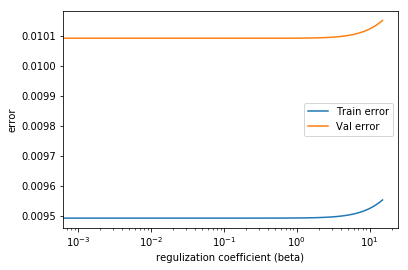

In [75]:
t_start=time.time()
print("The number of CPU is:" + str(mp.cpu_count()))
beta_array=train_model_loop(1, 10)
t_end=time.time()
print(f'The time cost is {t_end-t_start}s')

# plot error vs. beta
plt.figure()
plt.semilogx(beta_range, error_train_reg, label = 'Train error')
plt.semilogx(beta_range, error_cv_reg, label = 'Val error')
plt.xlabel('regulization coefficient (beta)')
plt.ylabel('error')
plt.legend()

# print(error_cv_reg_multismpl.shape)
print(beta_array)
idx=error_cv_reg.argmin()
beta_best = beta_range[idx]
theta_best = theta_reg[idx]
error_test_reg=computeCost(test_data_norm, test_J, theta_best)

# print('The best value of THETA is ', theta_best)
print('The best value of BETA is ', beta_best)
# print('The test error with best THETA and BETA is ', error_test_reg)

# Prediction

In [59]:
print(r)

NameError: name 'r' is not defined

In [ ]:
t=data(test_data)

In [24]:
print(error_train_reg)
print(error_cv_reg_multismpl)
len(error_train_reg)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


NameError: name 'error_cv_reg_multismpl' is not defined

In [ ]:
t.polyFeature(2)
t.array.shape

In [ ]:
x=1